# Russian Troll Tweets Analysis
This is my attempt at putting to use my recent learnings in text analytics. I have never worked with text data before so it should be exciting.

What comes to mind when I think of tweet data is to analyze - 
1. What are the most trending hashtags?
2. When were people most tweeting? Are tweets spiking around the time of major events? - Common sense tells me **Yes**
3. Which users mention which users? Can a graph be made to see which are the most mentioned users?
4. Can some clusters be made for users tweeting on similar topics?
5. Can we predict users from their tweet contents!

In [2]:
# Basic library loading
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Read in the dataset required
troll = pd.read_csv('../input/tweets.csv')
print(troll.shape)
troll.head(2)

(203482, 16)


,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,1.868981e+09,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,NaN,NaN,NaN,#IslamKills Are you trying to say that there w...,7.123460e+17,NaN,"[""IslamKills""]",[],POSTED,[],NaN,NaN
1,2.571870e+09,detroitdailynew,1.476133e+12,2016-10-10 20:57:00,0.0,False,0.0,"Clinton: Trump should’ve apologized more, atta...",7.855849e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],"[""http://detne.ws/2e172jF""]",POSTED,[],NaN,NaN


So, our tweet data has 203,482 rows and 16 columns. It captures data about the *userid, tweetid, tweet text, hashtags, mentions* and the number of times a tweet was re-tweeted or favorited. We also see a datetime column *created_str*.

Let's check missing values in the dataframe!

In [4]:
troll.isnull().sum().sort_values(ascending = False)

in_reply_to_status_id    202923
retweeted_status_id      163831
favorite_count           145399
retweeted                145399
retweet_count            145399
source                   145398
user_id                    8065
tweet_id                   2314
text                         21
created_str                  21
created_at                   21
mentions                      0
posted                        0
expanded_urls                 0
hashtags                      0
user_key                      0
dtype: int64

We see around 21 missing values in the text column. Since this is the critical column to be analyzed, **we will drop rows with NaNs in the text column**

In [5]:
# drop NAs in the text column and update the troll dataframe
troll.dropna(subset = ['text'], inplace = True)

Lets check the data types of the columns and convert the *created_str* to datetime if its not already that way.

In [6]:
print(troll.dtypes)

user_id                  float64
user_key                  object
created_at               float64
created_str               object
retweet_count            float64
retweeted                 object
favorite_count           float64
text                      object
tweet_id                 float64
source                    object
hashtags                  object
expanded_urls             object
posted                    object
mentions                  object
retweeted_status_id      float64
in_reply_to_status_id    float64
dtype: object


Hmm, so <br>
1. *user_id*, *tweet_id*, *retweeted_status_id* and *in_reply_to_status_id* have been read in as a float when it should be of object data type - we dont want computations on this column. 
2. We also see that *created_str* has been imported as type object - this needs to be changed to datetime for further processing.

In [7]:
# convert created_str to datetime format
troll['created_str'] = pd.to_datetime(troll['created_str'])

# convert ids to object datatype
columns = ['user_id', 'tweet_id', 'retweeted_status_id', 
           'retweeted_status_id', 'in_reply_to_status_id']

for column in columns:
    troll[column] = troll[column].astype('object')

Check data types of output dataframe! Always good to do when you are just beginning! :)

In [8]:
troll.dtypes

user_id                          object
user_key                         object
created_at                      float64
created_str              datetime64[ns]
retweet_count                   float64
retweeted                        object
favorite_count                  float64
text                             object
tweet_id                         object
source                           object
hashtags                         object
expanded_urls                    object
posted                           object
mentions                         object
retweeted_status_id              object
in_reply_to_status_id            object
dtype: object

## What period of tweets does this data capture?
The *created_str* column would help us know this!

In [9]:
start_date_tweet = troll['created_str'].min()
end_date_tweet = troll['created_str'].max()

print(start_date_tweet, end_date_tweet)

2014-07-14 18:04:55 2017-09-26 09:05:32


We have ~3 years of tweets starting **14th July 2014** until the **26th of September 2017**! Times appear with these dates, so let's create a new column to hold only the date component of this! 

In [10]:
# created_str_data holds the date component of the created_str column
troll['created_str_date'] = pd.to_datetime(troll['created_str'].dt.date)

## Check the trend of these tweets against time!
Since each row is one tweet on a given data (as given in the *created_str_date*), lets count the number of times a date appears and that gives us the number of tweets on that day!

In [11]:
# Count the number of times a date appears in the dataset and convert to dataframe
tweet_trend = pd.DataFrame(troll['created_str_date'].value_counts())

# index is date, columns indicate tweet count on that day
tweet_trend.columns = ['tweet_count']

# sort the dataframe by the dates to have them in order
tweet_trend.sort_index(ascending = True, inplace = True)

Text(0,0.5,'Tweet Count')

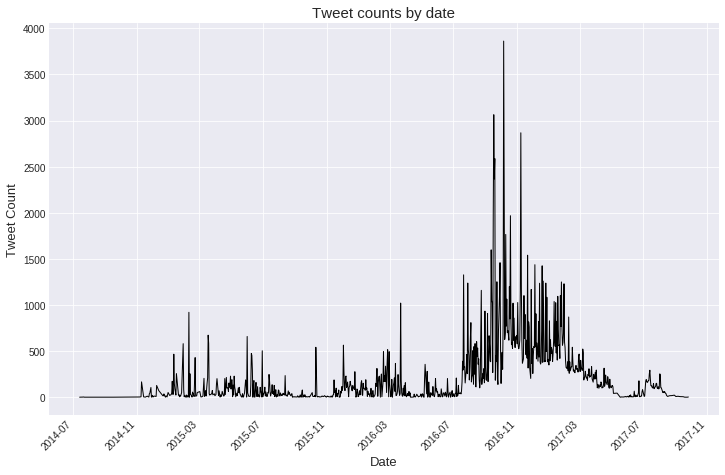

In [16]:
# make a line plot of the tweet count data and give some pretty labels! ;)
# the 'rot' argument control x-axis ticks rotation
plt.style.use('seaborn-darkgrid')
tweet_trend['tweet_count'].plot(linestyle = "-", figsize = (12,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

The nice part about having a datetime index is the pretty x-axis ticks it gives us! 

**If these tweets really had to impact the way of the US presidential elections, these tweets would be most numerous during important parts of the trump rally or milestones in the trump rally.** Let's get these dates online and try to map that data on with the line plot! 

[Important Dates in Trump's presidential elections](https://www.reuters.com/article/us-usa-election-timeline-factbox/timeline-pivotal-moments-in-trumps-presidential-campaign-idUSKBN1341FJ)

In [17]:
# these are dates corresponding to important dates from the trump campaign.
dates_list = ['2015-06-16', '2015-12-07', '2016-02-01',
              '2016-03-01', '2016-03-03', '2016-03-11',
              '2016-05-03', '2016-05-26', '2016-06-20', 
              '2016-07-15', '2016-07-21', '2016-08-17',
              '2016-09-01', '2016-10-07', '2016-11-08']

# create a series of these dates.
important_dates = pd.Series(pd.to_datetime(dates_list))

# add columns to identify important events, and mark a 0 or 1.
tweet_trend['Important Events'] = False
tweet_trend.loc[important_dates, 'Important Events'] = True
tweet_trend['values'] = 0
tweet_trend.loc[important_dates, 'values'] = 1

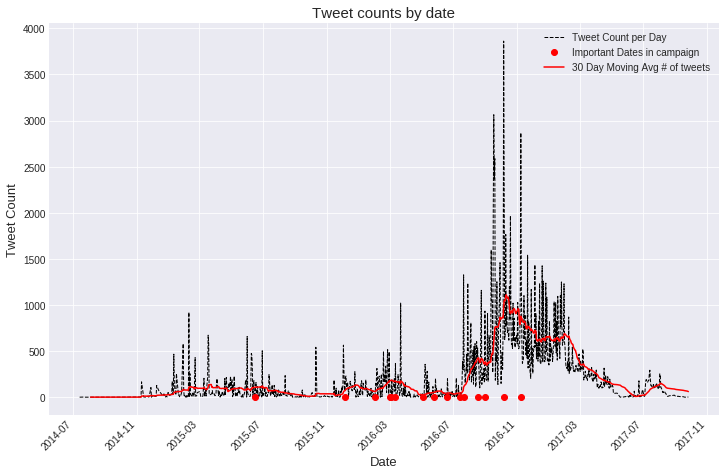

In [18]:
# plot the line chart for trend, a monthly average of tweet counts and add red dots to 
# mark important events.
plt.style.use('seaborn-darkgrid')
tweet_trend['tweet_count'].plot(linestyle = "--", 
                                figsize = (12,8), rot = 45, 
                                color = 'k',
                                label = 'Tweet Count per Day',
                               linewidth = 1)

# plot dots for where values in the tweet_trend df are 1
plt.plot(tweet_trend[tweet_trend['Important Events'] == True].index.values,
         tweet_trend.loc[tweet_trend['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none',
        label = 'Important Dates in campaign')

# Lets add a 30 day moving average on top to view the trend! Min_periods tells rolling() to
# use 10 points if 30 not available!
plt.plot(tweet_trend['tweet_count'].rolling(window = 30, min_periods = 10).mean(), 
         color = 'r', 
         label = '30 Day Moving Avg # of tweets')
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)
plt.legend(loc = 'best')

**The US president was elected on 8th November 2016 - the last red dot on the chart. We see a lot of tweet activity near the end of his campaign.** 

We can also calculate the percentage change in tweet counts between subsequent dates and then see if an important date relates with a spike!

In [19]:
# Calculate the percentage change in tweet counts
tweet_trend['Pct_Chg_tweets'] = tweet_trend['tweet_count'].pct_change()*100

# Lets see values only for the important dates. This Pct_Chg_tweets shows us the percentage
# change in tweets for the day of the event versus the previous day!
tweet_trend.loc[tweet_trend['values'] == 1,['tweet_count', 'Pct_Chg_tweets']]

,tweet_count,Pct_Chg_tweets
2015-06-16,3,50.000000
2015-12-07,219,204.166667
2016-02-01,18,1700.000000
2016-03-01,143,-71.052632
2016-03-03,6,-92.105263
2016-03-11,64,-69.523810
2016-05-03,38,216.666667
2016-05-26,6,-50.000000
2016-06-20,201,1156.250000
2016-07-15,47,17.500000


**The table above shows that for most of these dates, there was an increase in the tweet counts** - some days as large as 350%. However, there are some negative changes as well! **Keep in mind that these dates are not in order, these are just dates when there was an important event** - and the percent_change is with respect to the previous day!

Let's plot the percent change in tweet count with dates on the x axis to look at signs of correlation!

Text(0,0.5,'Tweet Count Change')

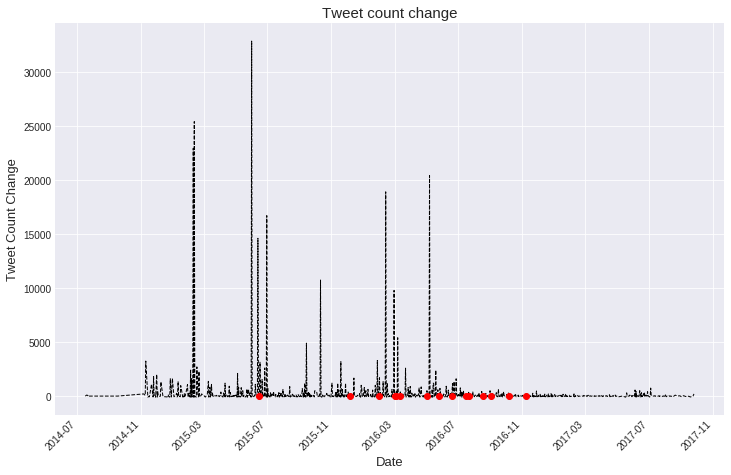

In [20]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# line plot of the percentage change in tweet counts
tweet_trend['Pct_Chg_tweets'].plot(linestyle = "--", figsize = (12,8), rot = 45, 
                                   color = 'k',
                                  linewidth = 1)
# add the dots for important events!
plt.plot(tweet_trend[tweet_trend['Important Events'] == True].index.values,
         tweet_trend.loc[tweet_trend['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none')
plt.title('Tweet count change', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count Change', fontsize = 13)

## Text Analytics Time!
So we see that the tweets contain extra elements like RT mentions, links and hashtags! Let's separate out these elements so that we can analyze just the tweet text or the hashtags as we so prefer!

In [21]:
# take a look at what the 'text' column holds
troll['text'].head(10)

0    #IslamKills Are you trying to say that there w...
1    Clinton: Trump should’ve apologized more, atta...
2    RT @ltapoll: Who was/is the best president of ...
3    RT @jww372: I don't have to guess your religio...
4    RT @Shareblue: Pence and his lawyers decided w...
5                               @ModicaGiunta me, too!
6    RT @MDBlanchfield: You’ll never guess who twee...
7    RT @100PercFEDUP: New post: WATCH: DIAMOND AND...
8    RT @AriaWilsonGOP: 3 Women Face Charges After ...
9    One of the ways to remind that #BlackLivesMatt...
Name: text, dtype: object

The table above shows that  - <br>
1. **Retweets** begin with the **keyword 'RT'**. These are followed by _@userkey_.
2. **Hashtags** begin with a **_#_** and are one continuous string with a space next to them!
3. **Links** begin with **_https://_ or _http://_** and can be present anywhere in the string.
4. **There can be multiple links and hashtags in a tweet, but retweet identifier is just one.**
5. **User mentions** begin with **'@'** and are a continuous word!

**First let's remove the RT mentions from tweets.**

In [22]:
# define a function that takes in a tweet and throws out the text without the RT.
def remove_retweet(tweet):
    '''Given a tweet, remove the retweet element from it'''
    text_only = []
    if len(re.findall("^RT.*?:(.*)", tweet)) > 0:
        text_only.append(re.findall("^RT.*?:(.*)", tweet)[0])
    else:
        text_only.append(tweet)
    return text_only[0]

# extract texts and place in a list
text_only = troll['text'].map(remove_retweet)

**Next, let's remove the links from these tweet texts so that we have a column for just the tweet text devoid of any links and RT mentions.**

In [23]:
# this method checks for links and removes these from the tweet provided!
def remove_links(tweet):
    '''Provide a tweet and remove the links from it'''
    text_only = []
    if len(re.findall("(https://[^\s]+)", tweet)) > 0:
        tweet = re.sub("(https://[^\s]+)", "", tweet)
    if len(re.findall("(http://[^\s]+)", tweet)) > 0:
        tweet = re.sub("(http://[^\s]+)", "", tweet)    
    text_only.append(tweet)
    return text_only[0]

text_no_links = text_only.map(remove_links)

**Lets remove hashtags from these!**

In [25]:
def remove_hashtags(tweet):
    '''Provide a tweet and remove hashtags from it'''
    hashtags_only = []
    if len(re.findall("(#[^#\s]+)", tweet)) > 0:
        tweet = re.sub("(#[^#\s]+)", "", tweet) 
    hashtags_only.append(tweet)
    return hashtags_only[0]

text_all_removed = text_no_links.map(remove_hashtags)

**Let's remove all extra spaces from the beginning and the end of the text that we got!**

In [26]:
def remove_extraneous(tweet):
    '''Given a text, remove unnecessary characters from the beginning and the end'''
    tweet = tweet.rstrip()
    tweet = tweet.lstrip()
    tweet = tweet.rstrip(")")
    tweet = tweet.lstrip("(")
    tweet = re.sub("\.", "", tweet)
    return tweet

text_clean = text_all_removed.map(remove_extraneous)

**At last, we remove the user mentions from the text_clean** But before we do that, lets store these user mentions in a new column within the dataframe!

In [30]:
# in case no mention present, we return "0"
def extract_mentions(tweet):
    '''Given a tweet, this function returns the user mentions'''
    mentions = []
    if len(re.findall('@[^\s@]+', tweet))>0:
        mentions.append(re.findall('@([^\s@]+)', tweet))
    else:
        mentions.append(["0"])
    return mentions[0]

# Put the user mentions in a new column in our dataframe
troll['user_mentions'] = text_clean.map(extract_mentions)

In [31]:
# Now lets remove the mentions from the tweet text
def remove_mentions(tweet):
    '''Given a text, remove the user mentions'''
    mentions = []
    if len(re.findall('@[^\s@]+', tweet))>0:
        tweet = re.sub('@[^\s@]+', "" , tweet)
        mentions.append(tweet)
    else:
        mentions.append(tweet)
    return mentions[0]

text_clean_final = text_clean.map(remove_mentions)

With the cleaned tweet text now available to us in the _Text_clean_ list, let's append it to our dataframe!

In [32]:
troll['tweet_text_only'] = text_clean_final

## What hashtags are being used the most?
First, lets use the function created above but use it in a way that we can extract the hashtags and not remove them!

In [33]:
# in case hashtags are not found, we will use "0" as the placeholder
def extract_hashtags(tweet):
    '''Provide a tweet and extract hashtags from it'''
    hashtags_only = []
    if len(re.findall("(#[^#\s]+)", tweet)) > 0:
        hashtags_only.append(re.findall("(#[^#\s]+)", tweet))
    else:
        hashtags_only.append(["0"])
    return hashtags_only[0]

# make a new column to store the extracted hashtags and view them!
troll['tweet_hashtags'] = troll['text'].map(extract_hashtags)
troll['tweet_hashtags'].head(10)

0                          [#IslamKills]
1                                    [0]
2                                    [0]
3                  [#ChristmasAftermath]
4                                    [0]
5                                    [0]
6                                    [0]
7                                    [0]
8                                    [0]
9    [#BlackLivesMatter, #BlackPressDay]
Name: tweet_hashtags, dtype: object

Nect we need to extract all unique hashtags from the hashtags column just created and take a value count on those!

In [34]:
# create a list of all hashtags
all_hashtags = troll['tweet_hashtags'].tolist()

# Next we observe that our all_hashtags is a list of lists...lets change that
cleaned_hashtags = []
for i in all_hashtags:
    for j in i:
            cleaned_hashtags.append(j)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_hashtag_series = pd.Series(cleaned_hashtags)
hashtag_counts = cleaned_hashtag_series.value_counts()

Let's first create a wordcloud of the most commonly used hashtags! This requires us to put the word list as a single string separated by spaces. The algorithm then counts the number of times each term appears and makes the words bigger/bolder commensurate to their frequency!

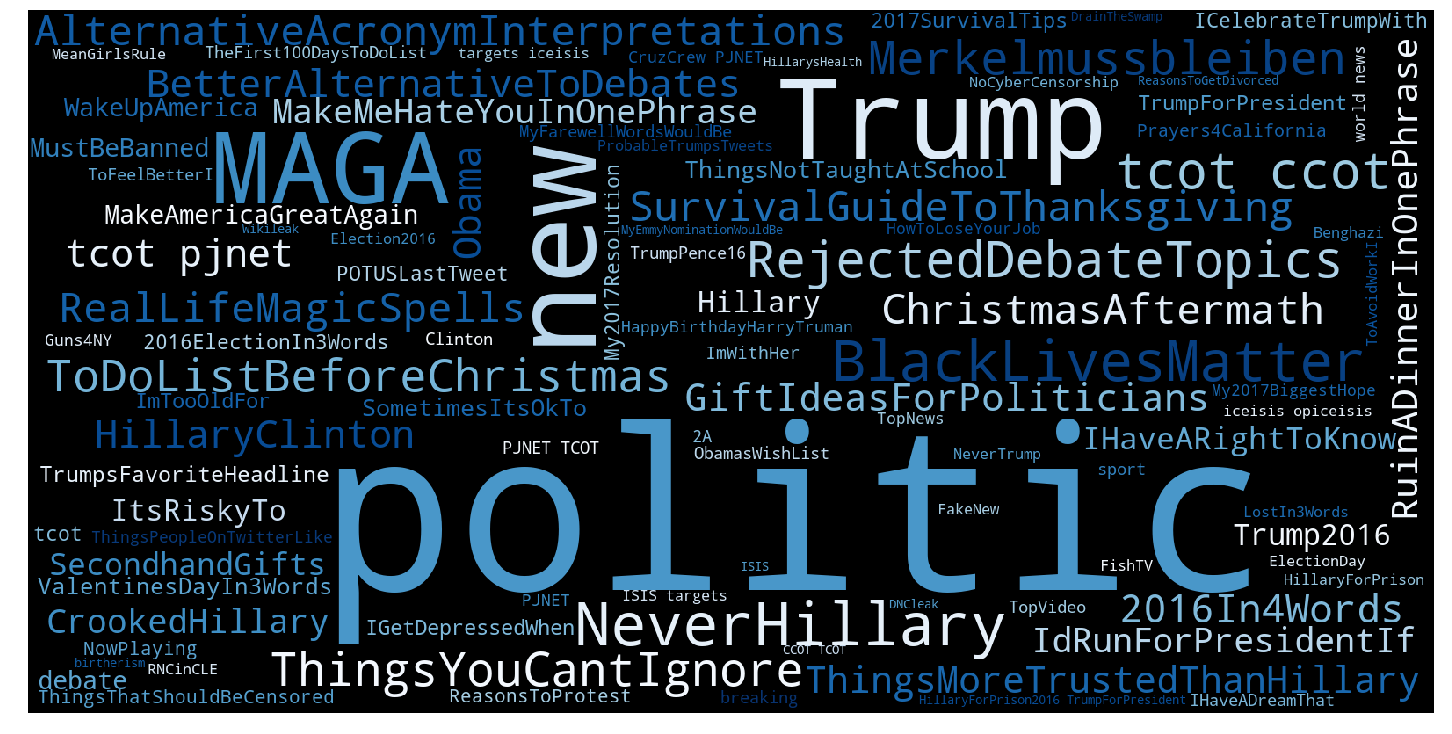

In [35]:
# Get hashtag terms from the series and convert to list
hashes = cleaned_hashtag_series.values
hashes = hashes.tolist()

# convert list to one string with all the words
hashes_words = " ".join(hashes)

# generate the wordcloud. the max_words argument controls the number of words on the cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width= 1600, height = 800, 
                      relative_scaling = 1.0, 
                      colormap = "Blues",
                     max_words = 100).generate(hashes_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

This is an excellent way to visually see the most common hashtags, but there is no way to quantify the frequency of each hashtag from this! Let's plot a barplot too!

Text(0,0.5,'Hashtags')

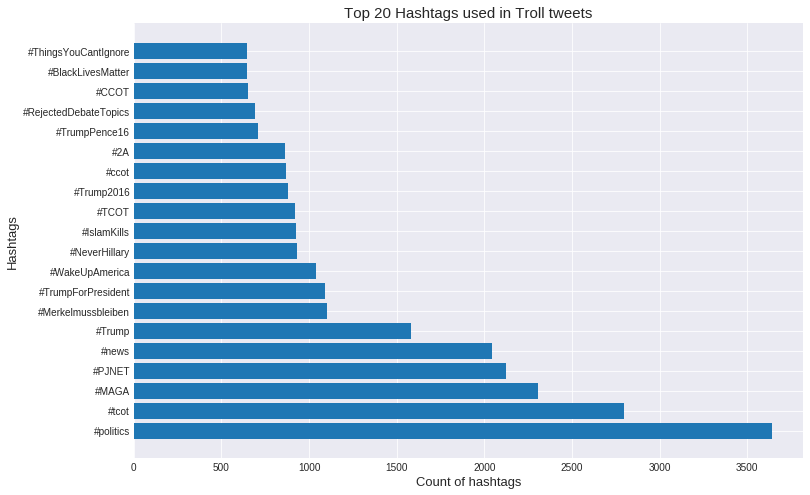

In [36]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (12,8))
plt.barh(y = hashtag_counts[1:21].index.values, width = hashtag_counts[1:21])
plt.title("Top 20 Hashtags used in Troll tweets", fontsize = 15)
plt.xlabel('Count of hashtags', fontsize = 13)
plt.ylabel('Hashtags', fontsize = 13)

Looking at the top hashtags, we find that the most common hashtags in use - <br>
1. **#TCOT**  
2. **#POLITICS** 
3. **#PJNET**
4. **#MAGA**
5. **#Trump**

are all in support of the current president's campaign! Looks like the trolls were mostly supporting his candidacy!

Among the top 20 used hashtags, we see that  **#WAKEUPAMERICA, #P2, @HILLARY** are against the candidacy but these have been used far fewer times than others!
 
**#2A** - refers to the Second Amendment of the US constitution to keep and bear arms which the president supports!

Surprisingly, these trolls also tweeted with the hastag **#MERKELMUSSBLEIBEN** which is in support of the German Chancellor - Angela Merkel and translates to 'Merkel Must Stay'

## Were these hashtags used most just before the presidents campaign?

To analyze this, we will use the top 6 hashtags and a count of how many times these were used on the dates provided in the *created_str_date*. 

Let's first extract the dates and the hashtags used on those dates. We would then count each top hashtag in these and proceed.

In [37]:
# Create a dataframe with just the date and the hashtags in the tweet on that date
hashtag_date_df = troll[['created_str_date', 'tweet_hashtags']]
hashtag_date_df = hashtag_date_df.reset_index(drop = True)

# extract a list of hashtags from the dataframe
all_hashtags = hashtag_date_df['tweet_hashtags'].tolist()

hashtag_date_df.head()

,created_str_date,tweet_hashtags
0,2016-03-22,[#IslamKills]
1,2016-10-10,[0]
2,2017-02-22,[0]
3,2016-12-26,[#ChristmasAftermath]
4,2017-08-06,[0]


In [38]:
# For the top 6 hashtags, lets calculate how many times that appears against each date!
count_dict = {}
for i in hashtag_counts.index.values[1:7]:
    count_hash = []
    for j in all_hashtags:
        count_hash.append(j.count(i))
    count_dict[i] = count_hash

In [39]:
# create a dataframe from the hashtags
hashtag_count_df = pd.DataFrame(count_dict)

# concatenate this dataframe with the hashtag_count_df
hashtag_count_df = pd.concat([hashtag_date_df, hashtag_count_df], axis = 1)

In [40]:
hashtag_count_df.head()

,created_str_date,tweet_hashtags,#politics,#tcot,#MAGA,#PJNET,#news,#Trump
0,2016-03-22,[#IslamKills],0,0,0,0,0,0
1,2016-10-10,[0],0,0,0,0,0,0
2,2017-02-22,[0],0,0,0,0,0,0
3,2016-12-26,[#ChristmasAftermath],0,0,0,0,0,0
4,2017-08-06,[0],0,0,0,0,0,0


Each column above is a hashtag and each cell underneath tells us the count of times that hashtag appeared in a tweet on that date! **We now need to summarise this data at the monthly level to get a sense of the month-on-month usage of these hashtags!**

In [41]:
# change the created_str column into datetime format and extract just the date from it
hashtag_count_df['created_str_date'] = pd.to_datetime(hashtag_count_df['created_str_date'])

# set the index so as to plot the time series
hashtag_count_df.set_index('created_str_date', inplace = True)

# get a monthly sum of the tweets for each of these hashtags
hashtag_count_df_pivot = hashtag_count_df.resample('M').sum()

# replace 0 with nan so that these can be removed in rows where they are all NaNs
hashtag_count_df_pivot.replace(0, np.nan, inplace = True)
hashtag_count_df_pivot.dropna(how = 'all', inplace = True, axis = 0)

# replace NaNs back by 0s so that we can plot
hashtag_count_df_pivot.replace(np.nan, 0, inplace = True)
hashtag_count_df_pivot

,#politics,#tcot,#MAGA,#PJNET,#news,#Trump
created_str_date,,,,,,
2015-02-28,2.0,0.0,0.0,0.0,2.0,0.0
2015-03-31,1.0,0.0,0.0,0.0,9.0,0.0
2015-04-30,45.0,4.0,0.0,2.0,149.0,0.0
2015-05-31,41.0,30.0,0.0,64.0,163.0,0.0
2015-06-30,26.0,61.0,0.0,17.0,124.0,0.0
2015-07-31,59.0,13.0,0.0,3.0,307.0,2.0
2015-08-31,3.0,1.0,0.0,1.0,9.0,24.0
2015-09-30,0.0,0.0,0.0,0.0,1.0,0.0
2015-10-31,20.0,34.0,0.0,11.0,1.0,6.0


Text(0.5,0,'Date')

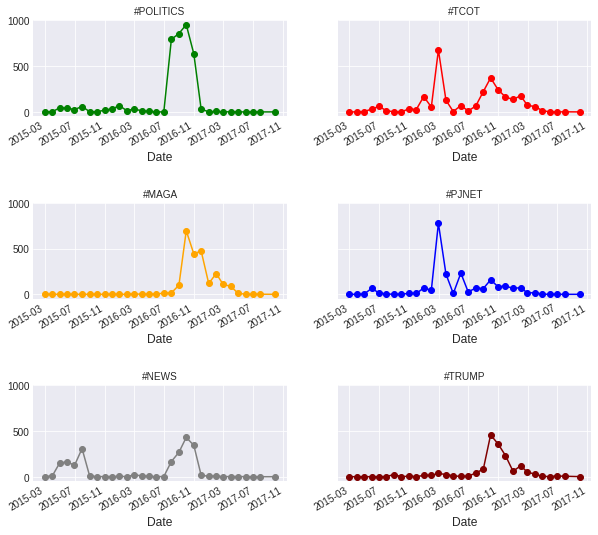

In [42]:
plt.style.use('seaborn-darkgrid')
# create a 3 by 2 subplot to hold the trend of all hashtags
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = subplots(nrows = 3,
                                                       ncols = 2,
                                                       sharey = True,
                                                       figsize = (10,8))

plt.subplots_adjust(top = 1, hspace = 0.9)
hashtag_count_df_pivot['#politics'].plot(linestyle = "-", marker = "o", color = "green",ax = ax1)
ax1.set_title("#POLITICS", fontsize = 10)
ax1.set_xlabel('Date', fontsize = 12)

hashtag_count_df_pivot['#tcot'].plot(linestyle = "-", marker = "o", color = "red", ax = ax2)
ax2.set_title("#TCOT", fontsize = 10)
ax2.set_xlabel('Date', fontsize = 12)

hashtag_count_df_pivot['#MAGA'].plot(linestyle = "-", marker = "o", color = "orange", ax = ax3)
ax3.set_title("#MAGA", fontsize = 10)
ax3.set_xlabel('Date', fontsize = 12)

hashtag_count_df_pivot['#PJNET'].plot(linestyle = "-", marker = "o", color = "blue",ax = ax4)
ax4.set_title("#PJNET", fontsize = 10)
ax4.set_xlabel('Date', fontsize = 12)

hashtag_count_df_pivot['#news'].plot(linestyle = "-", marker = "o", color = "grey", ax = ax5)
ax5.set_title("#NEWS", fontsize = 10)
ax5.set_xlabel('Date', fontsize = 12)

hashtag_count_df_pivot['#Trump'].plot(linestyle = "-", marker = "o", color = "maroon", ax = ax6)
ax6.set_title("#TRUMP", fontsize = 10)
ax6.set_xlabel('Date', fontsize = 12)

**We see that most of these hashtags picked up in the year 2016 near March or later in July, close to the elections! This is also the time when alleged interference by Russian trolls started!** 

We see the largest peak in the **#politics**.  Maybe tweeting about politics got these trolls the largest following!

## Lets look at user mentions!
We already have the user mentions in a column in our **troll** dataframe! Let's create a dataframe with each user's tweet with the user mentions against it! 

In [43]:
troll['user_mentions'].head(10)

0               [0]
1               [0]
2               [0]
3               [0]
4               [0]
5    [ModicaGiunta]
6               [0]
7               [0]
8               [0]
9               [0]
Name: user_mentions, dtype: object

Let's now separate out the *user_key* and *user_mentions* columns from this dataframe!

In [44]:
user_mention = troll.loc[:, ['user_key', 'user_mentions']]
user_mention.head(6)

,user_key,user_mentions
0,ryanmaxwell_1,[0]
1,detroitdailynew,[0]
2,cookncooks,[0]
3,queenofthewo,[0]
4,mrclydepratt,[0]
5,giselleevns,[ModicaGiunta]


Remove rows where no user is mentioned! These are rows where the *user_mentions* column has a [0].

In [45]:
row_remove_mask = user_mention['user_mentions'].map(lambda x: "0" in x)

This gives us a T/F series - **True** where *user_mentions* are empty, **False** otherwise. How many rows are we removing?

In [46]:
np.sum(row_remove_mask)

162275

Let's remove these rows!

In [47]:
# keep rows where row_remove_mask is FALSE
user_mention_df = user_mention.loc[~row_remove_mask, :]
user_mention_df.reset_index(drop = True, inplace = True)
user_mention_df.head(10)

,user_key,user_mentions
0,giselleevns,[ModicaGiunta]
1,laurabaeley,"[21WIRE, KellyannePolls]"
2,brianaregland,[Migos]
3,michellearry,[sendavidperdue]
4,melvinsroberts,"[WorldOfHashtags, TheRyanAdams, bryanadams]"
5,puredavie,[midnight]
6,hyddrox,"[FoxNews, CNN]"
7,hyddrox,[greta]
8,willisbonnerr,[trueblackpower]
9,lagonehoe,[amjoyshow]


This gives us each user and the user they mentioned. For meaningful analysis, we want it such that each row has a user against **one** user and not multiple! Let's do that now!

In [48]:
# for each row, create a one-to-one tuple of user and his user mention
new_list = []
for i in range(len(user_mention_df)):
    for j in user_mention_df.loc[i, "user_mentions"]:
        (a,b) = (user_mention_df.loc[i, 'user_key'], j)
        new_list.append((a,b))

We now have a tuple with each user -> user_mention value. Lets get a dataframe from this!

In [49]:
user_mention_clean_df = pd.DataFrame({"User_Key": [a for (a,b) in new_list],
                                     "User_Mention": [b for (a,b) in new_list]})
user_mention_clean_df.head()

,User_Key,User_Mention
0,giselleevns,ModicaGiunta
1,laurabaeley,21WIRE
2,laurabaeley,KellyannePolls
3,brianaregland,Migos
4,michellearry,sendavidperdue


#### In Part 2 of this analysis, we will take the *user_mention_clean_df* to R to analyse the graph of user mentions!

## Hashtags based clustering
Can we get some cluster of users who use similar hashtags? First we will create a dataframe which holds the *user_key* and the *tweet_hashtags*.

In [50]:
# create a df with user and hashtags in one tweet
user_hashtag_df = troll[['user_key', 'tweet_hashtags']]
user_hashtag_df = user_hashtag_df.reset_index(drop = True)

In [51]:
# Lets remove the rows where no hashtags were used
row_remove_mask = user_hashtag_df['tweet_hashtags'].map(lambda x: "0" in x)

# Remove these rows from the user hashtag df
user_hashtag_df_clean = user_hashtag_df.loc[~row_remove_mask, :]
user_hashtag_df_clean.reset_index(drop = True, inplace = True)
user_hashtag_df_clean.head()

,user_key,tweet_hashtags
0,ryanmaxwell_1,[#IslamKills]
1,queenofthewo,[#ChristmasAftermath]
2,hiimkhloe,"[#BlackLivesMatter, #BlackPressDay]"
3,jasper_fly,[#myfarewellwordswouldbe]
4,giselleevns,[#My2017BiggestHope]


In [52]:
# separate out all hashtags used.
all_hashtags = user_hashtag_df_clean['tweet_hashtags']

Okay, so what I wanted was to create columns with the different hashtags used as the column names and the count of the number of times they appear in a tweet by a person as the value. The code below should have done that, however, I find that it eats up all my RAM and crashes the Kernel. This is because there are around 28k unique hashtags used in around 100,000 different tweets.

In [53]:
# count_dict = {}
# count_df = pd.DataFrame()
# for i in range(len(hashtag_counts.index.values)):
#     count_hash = all_hashtags.map(lambda x: x.count(hashtag_counts.index.values[i]))
#     count_dict[i] = count_hash
#     if i == 5000:
#         count_df = pd.DataFrame(count_dict)
#         count_dict = {}
#     elif i % 5000 == 0:
#         count_df = pd.concat([count_df, pd.DataFrame(count_dict)])
#         count_dict = {}
#     else:
#         next

So my alternate strategy is to count the number of tweets with hashtags that a hashtag appears in and filter out those hashtags that are present in less than 50 tweets. Hopefully this should give me a less dramatic dataframe to work with.

In [54]:
# get hashtags that qualify - present in 50 or more tweets
qualify_hashtags_mask = (hashtag_counts >= 50)
qualify_hashtags = hashtag_counts[qualify_hashtags_mask]

# remove the "0" hashtags
qualify_hashtags = qualify_hashtags.drop(labels = "0")
qualify_hashtags.head()

#politics    3638
#tcot        2799
#MAGA        2306
#PJNET       2121
#news        2046
dtype: int64

***qualify_hashtags* now has 435 hashtags that are present in 50 or more different tweets.** Wow! Thats such a reduction from the 28000 unique hashtags that we originally had! 

My hope is that now I should be able to count how many times those appear in the tweets and then make the dataframe I intended to above!

In [55]:
# lets count the number of times these qualified hashtags appear in the tweets with hashtags
count_dict = {}

for i in qualify_hashtags.index.values:
    count_hash = all_hashtags.map(lambda x: x.count(i))
    count_dict[i] = count_hash

# create a dataframe from the hashtags and their counts in tweets
hashtag_count_df = pd.DataFrame(count_dict)

# concatenate this dataframe with the hashtag_count_df
user_hashtag_count_df = pd.concat([user_hashtag_df_clean, hashtag_count_df], axis = 1)

Okay, for each user now we have the count of the qualifying hashtags in each of their tweets. Lets group this by the user and get a sum of the counts of hashtags used!

In [56]:
# group by user_key and get the sum of times they have used a hashtag
user_hashtag_group = user_hashtag_count_df.groupby('user_key').agg('sum').reset_index()
user_hashtag_group.head()

,user_key,#politics,#tcot,#MAGA,#PJNET,#news,#Trump,#Merkelmussbleiben,#TrumpForPresident,#WakeUpAmerica,#NeverHillary,#IslamKills,#TCOT,#Trump2016,#ccot,#2A,#TrumpPence16,#RejectedDebateTopics,#CCOT,#BlackLivesMatter,#ThingsYouCantIgnore,#TrumpTrain,#MakeAmericaGreatAgain,#ToDoListBeforeChristmas,#pjnet,#SurvivalGuideToThanksgiving,#AlternativeAcronymInterpretations,#p2,#…,#BetterAlternativeToDebates,#ChristmasAftermath,#RealLifeMagicSpells,#Hillary,#ThingsMoreTrustedThanHillary,#GiftIdeasForPoliticians,#2016In4Words,#HillaryClinton,#RuinADinnerInOnePhrase,#MakeMeHateYouInOnePhrase,#IdRunForPresidentIf,...,#MakeSexAwkwardIn5Words,#WhatILearnedToday,#IShouldGetAMedalFor,#obama,#MentalIllnessIcebreakers,#TEAPARTY,#TrumpPence,#showbiz,#MyNewCatchPhraseIs,#np,#ThursdayThoughts,#P…,#WearHoodieForTrayvon,#MySaturdayNightIn4Words,#VPDebate,#SCOTUS,#fakenews,#TrusTED,#WriteAPanel,#HRC,#TeaPartyNews,#WCW,#ImAlwaysForgetting,#IfTheMediaRiggedTheElection,#SongsHannibalWouldSing,#SundayMorning,#InHonorOf,#Military,#HRCOriginalBirther,#Blacks4Trump,#BernieSanders,#TexasJihad,#TheResistance,#demndebate,#PJnet,#WednesdayWisdom,#AndThatsHowIWentViral,#IfHillaryBecomesPresident,#NotMyPresident,#WeedTV
0,4mysquad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6druz,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,_billy_moyer_,4,30,0,16,2,3,0,0,9,0,0,10,5,15,11,0,0,18,0,0,2,2,0,7,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,_nickluna_,4,80,41,89,14,35,0,30,36,15,41,29,14,27,17,7,0,25,12,0,12,12,0,17,0,0,9,10,0,0,33,7,6,0,0,7,0,0,0,...,0,0,0,3,0,2,1,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,2,0,1,0,2,0,0,0,2,3,0,0,0,0,0
4,_sashalapin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**In Part 2 of this analysis, we take a look at clusters of users based on hashtags used!**

## Lets look at user wise tweet text
Recall that we had created a *tweet_text_only* column that contained just the tweet text devoid of any links, RT, mentions or hashtags! Lets get a user wise text dataframe!

In [57]:
user_tweet_df = troll.loc[:, ['user_key', 'tweet_text_only']]
user_tweet_df.head()

,user_key,tweet_text_only
0,ryanmaxwell_1,Are you trying to say that there were no terro...
1,detroitdailynew,"Clinton: Trump should’ve apologized more, atta..."
2,cookncooks,Who was/is the best president of the past 25 y...
3,queenofthewo,I don't have to guess your religion!
4,mrclydepratt,Pence and his lawyers decided which of his off...


# Users!
We also have data on the users who write these tweets! What can we gather from this data?
Let's just look at the data first.

In [58]:
users = pd.read_csv('../input/users.csv')
users.head(2)

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
0,18710816.0,near Utah Ave & Lighthouse an,Robby Delaware,304.0,11484.0,Pacific Time (US & Canada),False,en,RobbyDelaware,"I support the free movement of people, ideas a...",Wed Jan 07 04:38:02 +0000 2009,17.0,670.0,13.0
1,100345056.0,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,1053.0,31858.0,NaN,False,en,SCOTTGOHARD,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,Tue Dec 29 23:15:22 +0000 2009,2774.0,1055.0,35.0


We see information about *user_id*, *user_name*, *follower_count*, *language*, etc.

## Where are users from and what language do they use?
Lets create a sankey plot (also called alluvial plot in R) to get a sense of which time zone are the users from and what language they speak!

In [59]:
# First we get a count of users from each time-zone and language combination!
user_loc_lang = users.groupby(['time_zone', 'lang'])['id'].agg('count').reset_index()
user_loc_lang.rename(columns = {'id':'user_count'}, inplace = True)
user_loc_lang.head(5)

,time_zone,lang,user_count
0,Abu Dhabi,en,1
1,Arizona,en,1
2,Baku,en,2
3,Baku,ru,4
4,Berlin,de,10


Text(0.5,1,'User profile')

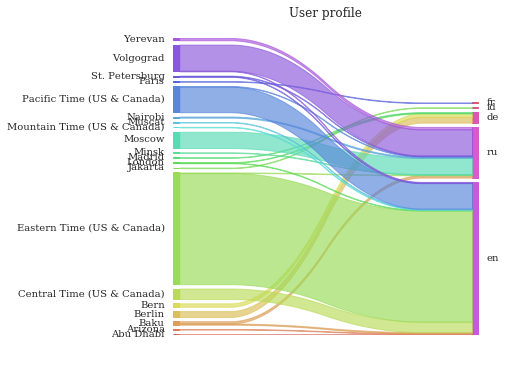

In [60]:
# This is a custom package installed within kaggle kernel
from pySankey import sankey
sankey.sankey(user_loc_lang['time_zone'],
              user_loc_lang['lang'],
              leftWeight = user_loc_lang['user_count'],
              rightWeight = user_loc_lang['user_count'], 
              fontsize = 10)
plt.title("User profile")

The above chart shows the user profile in the troll tweet users. **English speaking** users come from **US, Canada & Arizona**. *Russian* speaking users come from *Moscow, Volgograd, Yerevan and Minsk*! All french speaking users are from Paris. This makes sense!

## When were these accounts created?
The *created_at* column in the **users** dataframe captures this information!

In [61]:
# First we convert the created_at to datetime and then extract the date from this
users['created_at'] = pd.to_datetime(users['created_at'])
users['created_at_date'] = pd.to_datetime(users['created_at'].dt.date)

users['created_at_date'].head()

0   2009-01-07
1   2009-12-29
2   2011-02-04
3   2011-02-09
4   2011-12-29
Name: created_at_date, dtype: datetime64[ns]

Text(0,0.5,'Count of accounts created')

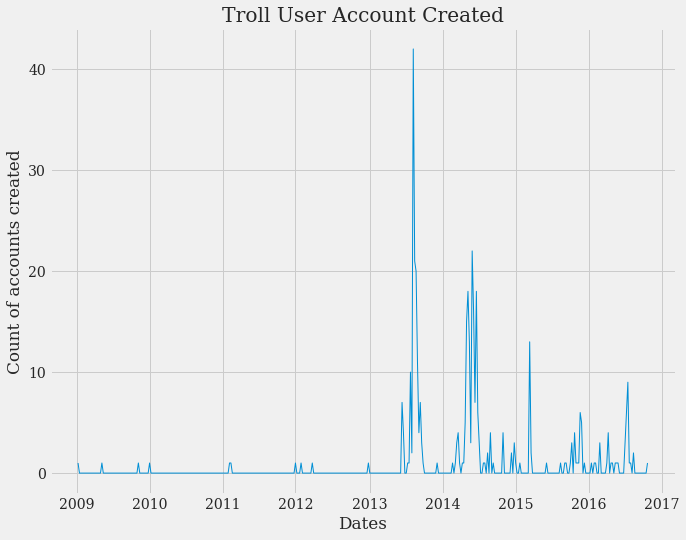

In [62]:
user_created = users.groupby('created_at_date')['id'].agg('count')

plt.style.use('fivethirtyeight')
user_created.resample('W',kind = 'period').sum().\
plot(linestyle = '-', figsize = (10,8), linewidth = 1)
title('Troll User Account Created')
xlabel('Dates')
ylabel('Count of accounts created')

Most troll accounts were created in the second half of 2013 or first half of 2014!

## Which user tweets the most?

In [63]:
user_tweet_count = troll.groupby('user_id')['text'].agg('count').reset_index()
user_tweet_count.rename(columns = {'text':'Tweet_count'}, inplace = True)

Let's merge this dataframe with the **users** data to get the associated *followers_count* and *name*.

In [64]:
user_tweet_count_df = user_tweet_count.merge(users,
                                      left_on = 'user_id',
                                      right_on = 'id')
user_tweet_count_df.head(2)

,user_id,Tweet_count,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count,created_at_date
0,18710816.0,31,18710816.0,near Utah Ave & Lighthouse an,Robby Delaware,304.0,11484.0,Pacific Time (US & Canada),False,en,RobbyDelaware,"I support the free movement of people, ideas a...",2009-01-07 04:38:02,17.0,670.0,13.0,2009-01-07
1,38875764.0,1,38875764.0,St-Petersburg,Olga,14.0,219.0,St. Petersburg,False,ru,Leecory,here i am~,2009-05-09 15:58:34,0.0,6.0,0.0,2009-05-09


A tweet count of the top 10 tweeting users follows-

Text(0,0.5,'User Name')

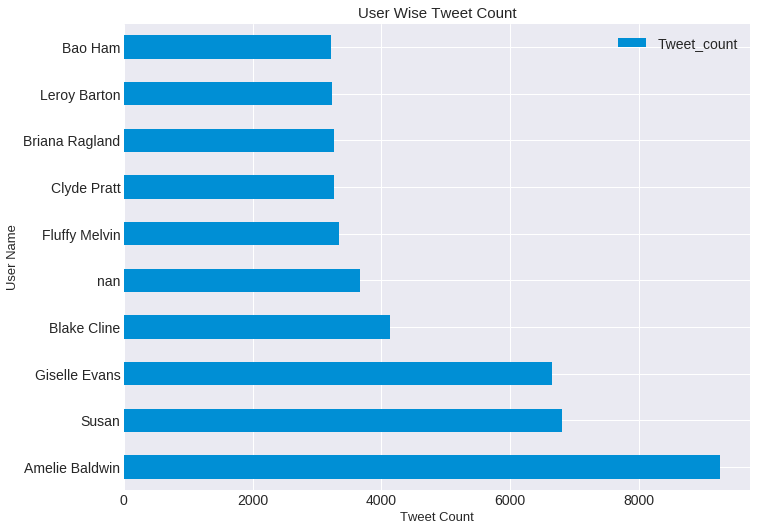

In [65]:
plt.style.use('seaborn-darkgrid')
user_tweet_count_df[['name', 'Tweet_count']].sort_values('Tweet_count', ascending = False)[:10].\
set_index('name').plot(kind = 'barh', figsize = (10,8))
title('User Wise Tweet Count', fontsize = 15)
xlabel('Tweet Count', fontsize = 13)
ylabel('User Name', fontsize = 13)

## Do a larger number of tweets mean higher number of followers?
Lets see if there is a linear correlation here!

In [66]:
correl = user_tweet_count_df['Tweet_count'].corr(user_tweet_count_df['followers_count'])
print("{0:.2f}".format(correl))

-0.03


Text(6000,80000,'Correlation is: -0.03')

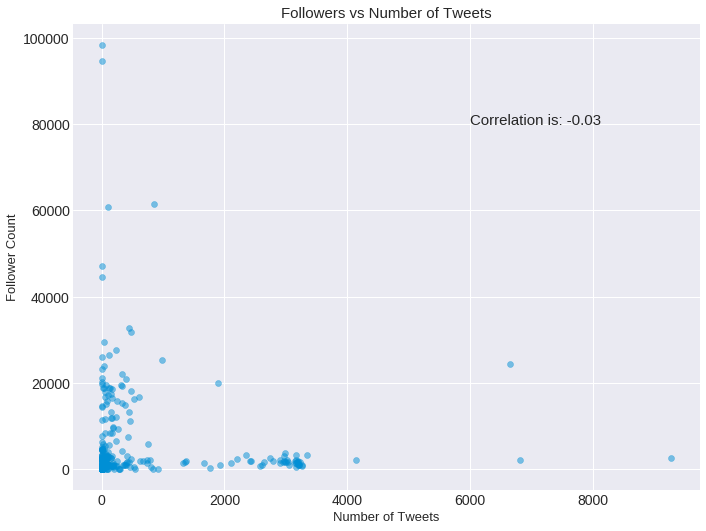

In [67]:
# Drawing a scatterplot of the tweet count with number of followers
fig = plt.figure(figsize = (10,8))
plt.style.use('seaborn-darkgrid')
plt.scatter(user_tweet_count_df['Tweet_count'], 
        user_tweet_count_df['followers_count'],
       marker = 'o',
       alpha = 0.5)
plt.title("Followers vs Number of Tweets", fontsize = 15)
plt.xlabel("Number of Tweets", fontsize = 13)
plt.ylabel("Follower Count", fontsize = 13)
plt.text(6000, 80000, s = "Correlation is: {0:.2f}".format(correl), fontsize = 15)

**We can see from the chart that no such correlation exists!** Most users have very low tweet counts but their followers range from very few to numerous!

## What are the languages with which users registered?
The table below shows that english is the most common language, followed by Russian and German!

In [68]:
user_tweet_count_df['lang'].value_counts()

en    273
ru     90
de     18
id      1
es      1
fr      1
Name: lang, dtype: int64

## Which users had the most influence?
We see that although there are only 90 users with language 'ru', there are 4 of them in the top 10 most followed users!

In [69]:
user_tweet_count_df[['name', 'lang', 'followers_count']].sort_values('followers_count', 
                                                               ascending = False)[:10]

,name,lang,followers_count
292,Максим Дементьев,ru,98412.0
6,Рамзан Кадыров,ru,94773.0
295,Jenna Abrams,en,61609.0
288,New York City Today,en,60897.0
281,Мюсли Лаврова,ru,47080.0
146,Холодная Война 2.0,ru,44470.0
234,Politweecs,en,32846.0
287,Washington Online,en,31729.0
297,Pigeon Today,en,29524.0
189,New Orleans Online,en,27745.0


Thank you for following along! This is the end of my exploratory analysis of the troll tweets! I will use some of the work I have done here to create an R notebook and run some additional text analytics. In [Part 2 ](https://www.kaggle.com/chadalee/russian-troll-tweet-analysis-part-2)(Grand Finale :P), we look at - <br>

1. **user_mention_clean_df** and try to see using a network graph, which users reference which other user and which user appears the most in between two links on the network!
2. **user_hashtag_group** and create clusters of users based on what they tweet about!
3. **user_tweet_df** and try to predict users based on their tweet texts!

In [70]:
# Lets write out these files as datasets so that they can be used in my next Kernel!
user_mention_clean_df.to_csv('User_Mentions.csv')
user_hashtag_group.to_csv('User_Hashtags.csv')
user_tweet_df.to_csv('User_Tweets.csv')